# Algorithms for Speech and NLP TD 4

In [1]:
import numpy as np
from nltk import Tree
import os
import nltk
from nltk.corpus import BracketParseCorpusReader

In [2]:
TREEPATH = os.path.join(os.getcwd(),'sequoia-corpus+fct.mrg_strict')

with open(TREEPATH,'r') as f:
    corpus = f.read()
    
sentences = corpus.split('( (SENT (')[1:]
len(sentences)


3099

### Get all possible word types in the corpus

In [3]:
types = []
idx = 0
idx = corpus.find('(',idx)
while idx!=-1:
    idx_end = corpus.find(' ',idx)
    t = corpus[idx+1:idx_end]
#     print(t)
    if t not in types:
        types.append(t)
    
    idx = corpus.find('(',idx_end)
# print(types)
len(types)

type_word = set()
for t in types:
    if len(t)>0:
        c = t.find('-')
        #     if t.find('-')==-1 and not len(t)==0:
        type_word.add(t[:c] if c !=-1 else t)
        #     if c!=-1 and not len(t)==0:
        #         type_word.add(t[:c])
        #     elif c==-1 and not len(t)==0:
        #         type_word.add(t)
    
        
type_word = list(type_word)
print(type_word)

['PRO', 'Srel', 'PROREL', 'VPinf', 'ADJWH', 'AP', 'AdP', 'CC', 'ET', 'Ssub', 'ADV', 'PROWH', 'I', 'VINF', 'ADVWH', 'VIMP', 'DETWH', 'VPpart', 'PREF', 'DET', 'Sint', 'VS', 'P+PRO', 'NPP', 'VN', 'CLO', 'PONCT', 'PP', 'VPP', 'ADJ', 'CS', 'COORD', 'V', 'NP', 'P+D', 'P', 'CLS', 'SENT', 'CLR', 'NC', 'VPR']


In [4]:
len(type_word)

41

### Remove all tags with a functional tags

In [9]:
corpus_out = corpus
for t in type_word:
#     print('searching: '+t+'-')
    idx = corpus_out.find('('+t+'-',0)
#     print(corpus_out[idx:idx+len(t)+1])
    while idx!=-1:
        idx_end = corpus_out.find(' ',idx)
#         print(corpus_out[idx:idx_end])
        if idx_end-idx > len(t)+1 and corpus_out[idx+1:idx_end] not in type_word:
#             print('replacing "' + corpus_out[idx:idx_end]+ '" with "'+t+'"')
            
            corpus_out = corpus_out.replace(corpus_out[idx:idx_end],'('+t)

        idx = corpus_out.find('('+t+'-',idx_end)
    
    idx = corpus_out.find("(NP::")
    while idx!=-1:
        idx_end = corpus_out.find(' ',idx)
#         print(corpus_out[idx:idx_end])
        if idx_end-idx > len(t)+1 and corpus_out[idx+1:idx_end] not in type_word:
#             print('replacing "' + corpus_out[idx:idx_end]+ '" with "'+"NP"+'"')
            
            corpus_out = corpus_out.replace(corpus_out[idx:idx_end],"(NP")

        idx = corpus_out.find("(NP::",idx_end)
        

In [10]:
with open('corpus_out.txt','w') as f:
    f.write(corpus_out)

### Split the corpus into trees

In [11]:
with open('corpus_out.txt','r') as f:
    text = f.readlines()

### Create splits

In [12]:
prop_train = 0.8
prop_test = 0.1
prop_val = 0.1

import numpy as np

# rand_idx = np.random.permutation(len(text))
rand_idx = range(len(text))
idx_end_train = int(prop_train*len(text))
idx_start_test = int((1-prop_test)*len(text))

corpus_train = text[:idx_end_train]
corpus_dev = text[idx_end_train:idx_start_test]
corpus_test = text[idx_start_test:]



In [13]:
print(len(corpus_train))
print(len(corpus_dev))
print(len(corpus_test))
len(corpus_train+corpus_dev+corpus_test)

2479
310
310


3099

### Converting the corpus to Chomsky Normal Format

In [14]:
import re

def convert_to_CNF(corpus_text):
    corpus_CNF = []
    for t in corpus_text:
        # set to Chomsky Normal Format
        tr = Tree.fromstring(t)
        tr.chomsky_normal_form()
        tr_rules = tr.productions() 
#         print(tr_rules)
        for i,rule in enumerate(tr_rules):
            tr_rules[i] = str(rule).split(' -> ')
            for j,part in enumerate(tr_rules[i]):
                tr_rules[i][j] = re.sub(r'\|.*$','',tr_rules[i][j])
                
        corpus_CNF.append(tr_rules)
        
    return corpus_CNF
    
    

In [15]:
t = corpus_test[4]
print(t)
tr = Tree.fromstring(t)
tr.chomsky_normal_form()
tr_rules = tr.productions()
print(tr_rules)

( (SENT (NP (DET Le) (NC Procès) (PP (P en) (NP (ADJ première) (NC instance))))))

[ -> SENT, SENT -> NP, NP -> DET NP|<NC-PP>, DET -> 'Le', NP|<NC-PP> -> NC PP, NC -> 'Procès', PP -> P NP, P -> 'en', NP -> ADJ NC, ADJ -> 'première', NC -> 'instance']


In [16]:
corpus_train_rules = convert_to_CNF(corpus_train)
corpus_dev_rules = convert_to_CNF(corpus_dev)
corpus_test_rules = convert_to_CNF(corpus_test)

### Extracting PCFGs

#### Version which handles unary rules (A -> B) with A and B non terminal

In [17]:
def extractPCFGu(corpus_train, corpus_dev, corpus_test):
    # We add the terminal nodes of the test set to the grammar
    
    grammar_parents = []
    grammar_daughters = {}
    probas = {}
    for SENT in corpus_train:
        for rule in SENT:
            if rule[0] not in grammar_parents:
                grammar_parents.append(rule[0])
                grammar_daughters[rule[0]] = []
                grammar_daughters[rule[0]].append(rule[1])
                probas[rule[0]] = {rule[1] : 1.0}   
            else:
                if rule[1] not in grammar_daughters[rule[0]]:
                    grammar_daughters[rule[0]].append(rule[1])
                    probas[rule[0]][rule[1]] = 1.0
                else:
                    probas[rule[0]][rule[1]] += 1.0
            

    for SENT in corpus_test:
        for rule in SENT:
            if rule[0] in grammar_parents:
                if rule[1].startswith("'") or rule[1].startswith('"'):
                    if rule[1] not in grammar_daughters[rule[0]]:
                        grammar_daughters[rule[0]].append(rule[1])
                        probas[rule[0]][rule[1]] = 1.0
                    else:
                        probas[rule[0]][rule[1]] += 1.0
                    
    for SENT in corpus_dev:
        for rule in SENT:
            if rule[0] in grammar_parents:
                if rule[1].startswith("'") or rule[1].startswith('"'):
                    if rule[1] not in grammar_daughters[rule[0]]:
                        grammar_daughters[rule[0]].append(rule[1])
                        probas[rule[0]][rule[1]] = 1.0
                    else:
                        probas[rule[0]][rule[1]] += 1.0  
                        
    for i,parent in enumerate(probas):
        nb_parent_daughters = sum([probas[parent][r] for r in probas[parent]])
        
        for daughter in probas[parent]:
            
            probas[parent][daughter] /= nb_parent_daughters                    
            
    #print(grammar_parents[1],probas[grammar_parents[1]])
    return grammar_parents,grammar_daughters,probas

#### Version which does not handle unaries

In [18]:
def extractPCFG(corpus_train, corpus_dev, corpus_test):
    # We add the terminal nodes of the test set to the grammar
    
    grammar_parents = []
    grammar_daughters = []
    probas = []
    for SENT in corpus_train:
        for rule in SENT:
            if rule[0] not in grammar_parents:
                grammar_parents.append(rule[0])
                grammar_daughters.append([])
                grammar_daughters[-1].append(rule[1])
                probas.append([])
                probas[-1].append([])
                probas[-1][-1] = 1.0
                
            else:
                idx_parent = grammar_parents.index(rule[0])
                if rule[1] not in grammar_daughters[idx_parent]:
                    grammar_daughters[idx_parent].append(rule[1])
                    probas[idx_parent].append([])
                    probas[idx_parent][-1] = 1.0
                else:
                    probas[idx_parent][grammar_daughters[idx_parent].index(rule[1])] += 1.0

    for SENT in corpus_test:
        for rule in SENT:
            if rule[0] in grammar_parents:
                idx_parent = grammar_parents.index(rule[0])
                if rule[1].startswith("'") or rule[1].startswith('"'):
#                     print(idx_parent,rule[1])
#                     print(rule[1] in grammar_daughters[idx_parent])
                    if rule[1] not in grammar_daughters[idx_parent]:
                        grammar_daughters[idx_parent].append(rule[1])
#                         print(rule[1] in grammar_daughters[idx_parent])
                        probas[idx_parent].append([])
                        probas[idx_parent][-1] = 1.0
                    else:
                        probas[idx_parent][grammar_daughters[idx_parent].index(rule[1])] += 1.0
                    
    for SENT in corpus_dev:
        for rule in SENT:
#             print(rule)
            if rule[0] in grammar_parents:
                idx_parent = grammar_parents.index(rule[0])
#                 print(rule)
                if rule[1].startswith("'") or rule[1].startswith('"'):
#                     print(idx_parent,rule[1])
#                     print(rule[1] in grammar_daughters[idx_parent])
                    if rule[1] not in grammar_daughters[idx_parent]:
                        grammar_daughters[idx_parent].append(rule[1])
#                         print(rule[1] in grammar_daughters[idx_parent])
                        probas[idx_parent].append([])
                        probas[idx_parent][-1] = 1.0
                    else:
                        probas[idx_parent][grammar_daughters[idx_parent].index(rule[1])] += 1.0             
            
    
    for i,parent_daughters in enumerate(probas):
        nb_parent_daughters = sum(parent_daughters)*1.0
        for j,daughter in enumerate(parent_daughters):
            probas[i][j] /= nb_parent_daughters
            
    
            
    
    
    return grammar_parents,grammar_daughters,probas

In [19]:
(grammar_parents, grammar_daughters, P) = extractPCFGu(corpus_train_rules,corpus_dev_rules,corpus_test_rules)

In [20]:
grammar = {'parents':grammar_parents,'daughters':grammar_daughters}

In [21]:
len(grammar['daughters'])

42

In [22]:
sum([len(t) for t in grammar['daughters']])

137

## CKY algorithm

#### Version which handles unaries

In [23]:
def P_CKY_u(words,grammar,probas):
    table = {}    
    back = {}
    for A in grammar['parents']:
        table[A] = np.zeros((len(words)+1,len(words)+1))
        back[A] = np.empty((len(words)+1,len(words)+1),dtype=object)
    
        for i in np.indices((len(words)+1,len(words)+1)):
            back[A][i] = {}

    for j in range(len(words)+1)[1:]:
        print('word '+str(j))
        for a,A in enumerate(grammar['parents']):
            daughters_list = grammar['daughters'][A]
            if words[j-1] in daughters_list:
                table[A][j-1,j] = probas[A][words[j-1]]
                
            added = True
            while added:
                added = False
                for b,B in enumerate(grammar['parents']):
                    if table[B][j-1,j] > 0 and B in daughters_list:
                        PROB = probas[A][B]*table[B][j-1,j]
                        if PROB > table[A][j-1,j]:
                            table[A][j-1,j] = PROB
                            back[A][j-1,j] = b
                            added = True
                            
                    
        for i in range(j-2,-1,-1):
            for k in range(i+1,j):
                #------- for all {A|A->BC in grammar} ------
                for a, A in enumerate(grammar['parents']):
                    for bc, BC in enumerate(grammar['daughters'][A]):
                        if len(BC.split(' '))==2: # Check that BC is actually not B 
                            B = BC.split(' ')[0]
                            b = grammar['parents'].index(B)
                            C = BC.split(' ')[1]
                            c = grammar['parents'].index(C)
                            if table[B][i,k]>0 and table[C][k,j]>0: #-- and table[i,k,B]>0 and table[k,j,C]>0---
                                #------- for all {A|A->BC in grammar}--------
                                PROB = probas[A][BC]*table[B][i,k]*table[C][k,j]
                                if table[A][i,j]<PROB:
                                    table[A][i,j] = PROB
                                    back[A][i,j] = [k,b,c]
                                    
                    added = True
                    daughters_list = grammar['daughters'][A]
                    while added:
                        added = False
                        for b,B in enumerate(grammar['parents']):
                            if table[B][i,j] > 0 and B in daughters_list:
                                PROB = probas[A][B]*table[B][i,j]
                                if PROB > table[A][i,j]:
                                    table[A][i,j] = PROB
                                    back[A][i,j] = b
                                    added = True
                        
    
    return back, table

In [24]:
def build_tree_u(words,grammar,back,table,start,end,index,S=''):
     
    indexes = back[grammar['parents'][index]][start,end] 
#     print(indexes)
    if indexes=={}:
        return words[start]
    else:
        if type(indexes) is int:
            S += "(" +grammar['parents'][indexes]+" "+ build_tree_u(words,grammar,back,table,start,end,indexes) +")"
        else:
            [k,b,c] = indexes
            S += "(" +grammar['parents'][b]+" "+ build_tree_u(words,grammar,back,table,start,k,b) +")"
            S += "(" +grammar['parents'][c]+" "+ build_tree_u(words,grammar,back,table,k,end,c) +")"
        return S

#### Version which does not

In [25]:
def P_CKY(words,grammar,probas):
    table = np.zeros((len(words)+1,len(words)+1,len(grammar['parents'])))
    back = np.zeros((len(words)+1,len(words)+1,len(grammar['parents']),3))
    for j in range(len(words)+1)[1:]:
        for a,A in enumerate(grammar['parents']):
            daughters_list = grammar['daughters'][a]
            if words[j-1] in daughters_list:
                table[j-1,j,a] = probas[a][daughters_list.index(words[j-1])]
        for i in range(j-2,-1,-1):
            for k in range(i+1,j):
                #------- for all {A|A->BC in grammar} ------
                for a, A in enumerate(grammar['parents']):
                    for bc, BC in enumerate(grammar['daughters'][a]):
                        if len(BC.split(' '))==2: # Check that BC is actually not B 
                            b = grammar['parents'].index(BC.split(' ')[0])   
                            c = grammar['parents'].index(BC.split(' ')[1])
                            if table[i,k,b]>0 and table[k,j,c]>0: #-- and table[i,k,B]>0 and table[k,j,C]>0---
                                #------- for all {A|A->BC in grammar}--------
                                PROB = probas[a][bc]*table[i,k,b]*table[k,j,c]
                                if table[i,j,a]<PROB:
                                    table[i,j,a] = PROB
                                    back[i,j,a] = [k,b,c]
    
    return back, table

In [26]:
def build_tree(words,grammar,back,table,start,end,index,S=''):
    
    indexes = back[start,end,index]
#     print(indexes)
    if any(indexes==[0,0,0]):
        return words[start]
    else:
        [k,b,c] = indexes.astype('int')
        S += "(" +grammar['parents'][b]+" "+ build_tree(words,grammar,back,table,start,k,b) +")"
        S += "(" +grammar['parents'][c]+" "+ build_tree(words,grammar,back,table,k,end,c) +")"
        return S

## Testing the full algorithm on sentences

In [27]:
def to_words(norm_sentence):
    norm_sentence = norm_sentence[7:]
    words = []
    idx = norm_sentence.find(' (')
    while idx!=-1:
        idx_end_type = norm_sentence.find(' ',idx+1)
        idx_end_word = norm_sentence.find(')',idx_end_type)
        word = norm_sentence[idx_end_type+1:idx_end_word]
        if word.find(' ')!=-1:
            word = word.split(' ')[-1] 
        if word.find("'")!=-1:
            words.append('"'+word+'"')
        else:
            words.append("'"+word+"'")
        idx = norm_sentence.find(' (',idx_end_word)
        
    return words
        

In [28]:
import nltk.draw as dr

num_sentence = 250
print(corpus_test[num_sentence])
words = to_words(corpus_test[num_sentence])
print(words)
print(len(words))
b,t = P_CKY_u(words,grammar,P)
idx_max = 1

tree = build_tree_u(words,grammar,b, t, 0,-1,idx_max)
tr = Tree.fromstring('( ( SENT'+ tree + '))')
# dr.draw_trees(tr)

( (SENT (NP (NC Page) (VPpart (VPP accédé) (NP (DET le) (NC 2006-08-07)))) (PONCT .)))

["'Page'", "'accédé'", "'le'", "'2006-08-07'", "'.'"]
5
word 1
word 2
word 3
word 4
word 5


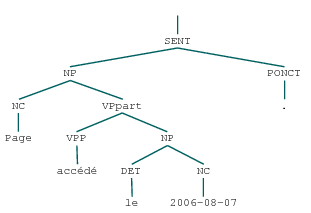

In [29]:
Tree.fromstring(corpus_test[num_sentence])

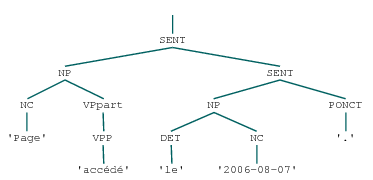

In [30]:
tr